In [ ]:
!pip install -q kaggle
!pip install -q scikit-image tqdm
!pip install -q tensorflow

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import json

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# Requirements
import json
import os, glob
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage import io
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:



# Requirements



# Remplace par tes identifiants
kaggle_username = "..."
kaggle_key = "..."

# Créer le dossier ~/.kaggle
os.makedirs("/root/.kaggle", exist_ok=True)

# Créer le fichier kaggle.json
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_key}, f)

# Modifier les permissions
!chmod 600 /root/.kaggle/kaggle.json


!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset


# Dézipper le dataset
dataset_dir = "/content/dataset/TB_Chest_Radiography_Database"

if not os.path.exists(dataset_dir):
    !unzip -q tuberculosis-tb-chest-xray-dataset.zip -d /content/dataset
    print("Dataset dézippé dans /content/dataset")
else:
    print("Le dataset existe déjà, pas besoin de dézipper")


print(os.listdir("/content/dataset"))
print("Normal images:", len(os.listdir("/content/dataset/TB_Chest_Radiography_Database/Normal")))
print("TB images:", len(os.listdir("/content/dataset/TB_Chest_Radiography_Database/Tuberculosis")))


# ANALYSE
DATASET_PATH = "/content/dataset/TB_Chest_Radiography_Database/"
CLASSES = ["Normal", "Tuberculosis"]

records = []
for cls in CLASSES:
    folder = os.path.join(DATASET_PATH, cls)
    files = sorted(glob.glob(os.path.join(folder, "*")))
    for f in tqdm(files, desc=f"Scanning {cls}"):
        try:
            img = io.imread(f)
            h,w = img.shape[:2]
            fmt = os.path.splitext(f)[1].lower()
            records.append({
                "path": f,
                "class": cls,
                "height": h,
                "width": w,
                "channels": img.ndim,
                "format": fmt,
                "ok": True
            })
        except Exception as e:
            records.append({"path": f, "class": cls, "height":None, "width":None, "channels":None, "format":None, "ok":False, "error":str(e)})

df = pd.DataFrame(records)
df["label"] = df["class"].map({"Normal":0, "Tuberculosis":1})

print(df["class"].value_counts())
print("\nImage size stats:")
print(df[["height","width"]].describe())





Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
tuberculosis-tb-chest-xray-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Le dataset existe déjà, pas besoin de dézipper
['TB_Chest_Radiography_Database']
Normal images: 3500
TB images: 700


Scanning Tuberculosis: 100%|██████████| 700/700 [00:05<00:00, 126.34it/s]

class
Normal          3500
Tuberculosis     700
Name: count, dtype: int64

Image size stats:
       height   width
count  4200.0  4200.0
mean    512.0   512.0
std       0.0     0.0
min     512.0   512.0
25%     512.0   512.0
50%     512.0   512.0
75%     512.0   512.0
max     512.0   512.0


Scanning Tuberculosis: 100%|██████████| 700/700 [00:05<00:00, 137.71it/s]


class
Normal          3500
Tuberculosis     700
Name: count, dtype: int64
       height   width
count  4200.0  4200.0
mean    512.0   512.0
std       0.0     0.0
min     512.0   512.0
25%     512.0   512.0
50%     512.0   512.0
75%     512.0   512.0
max     512.0   512.0


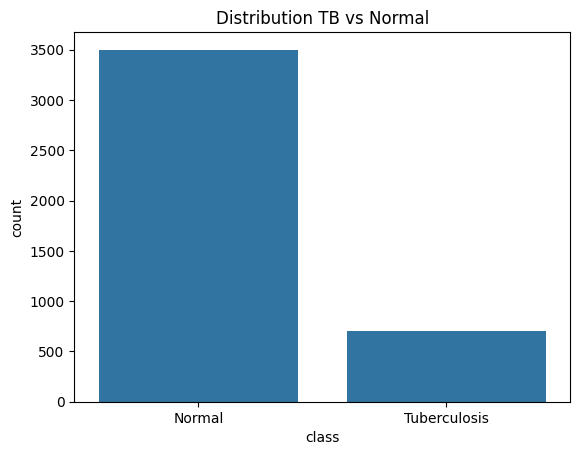

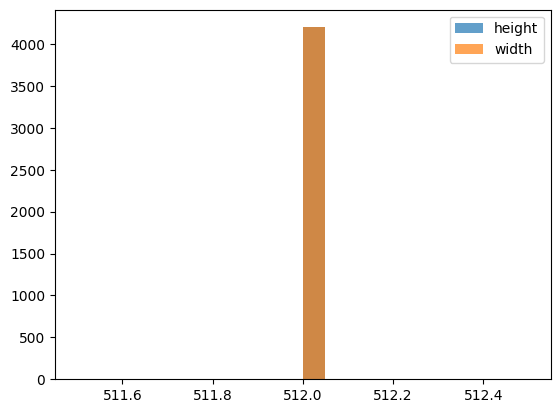

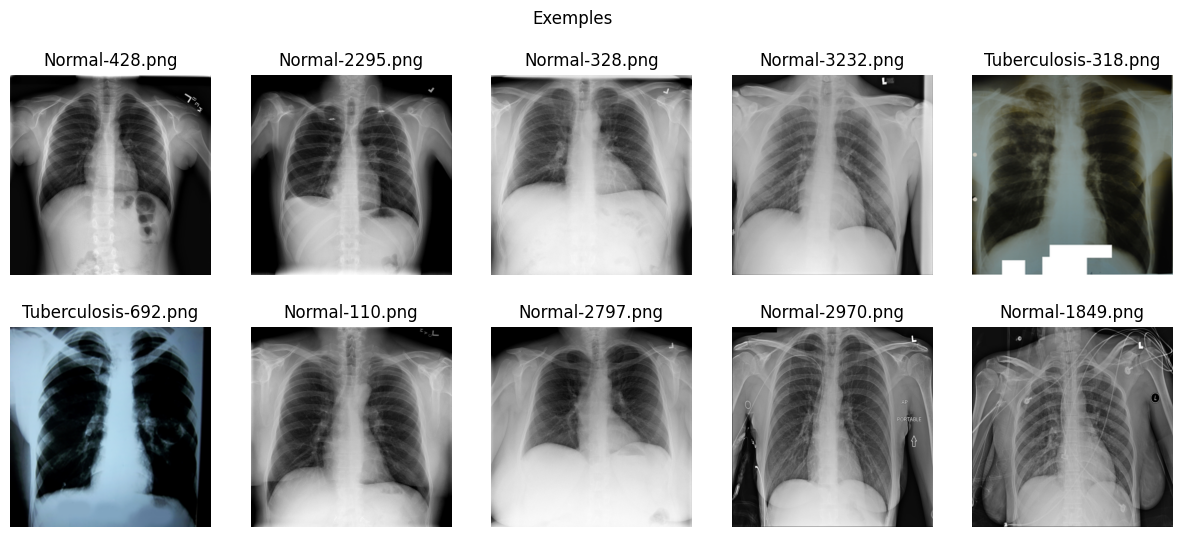

In [ ]:
# BUILD DATAFRAME (analyse)
# -------------------------
DATASET_PATH = "/content/dataset/TB_Chest_Radiography_Database/"
CLASSES = ["Normal", "Tuberculosis"]

records = []
for cls in CLASSES:
    folder = os.path.join(DATASET_PATH, cls)
    files = sorted(glob.glob(os.path.join(folder, "*")))
    for f in tqdm(files, desc=f"Scanning {cls}"):
        try:
            img = io.imread(f)
            h,w = img.shape[:2]
            records.append({
                "path": f,
                "class": cls,
                "height": h,
                "width": w,
                "channels": img.ndim,
                "ok": True
            })
        except Exception as e:
            records.append({"path": f, "class": cls, "height": None, "width": None, "channels": None, "ok": False, "error": str(e)})

df = pd.DataFrame(records)
df["label"] = df["class"].map({"Normal":0, "Tuberculosis":1})
print(df["class"].value_counts())
print(df[["height","width"]].describe())

# quick visuals
sns.countplot(x="class", data=df); plt.title("Distribution TB vs Normal"); plt.show()
plt.hist(df['height'].dropna(), bins=20, alpha=0.7, label='height'); plt.hist(df['width'].dropna(), bins=20, alpha=0.7, label='width'); plt.legend(); plt.show()
fig, axes = plt.subplots(2,5, figsize=(15,6))
for ax in axes.flatten():
    p = df.sample(1)["path"].values[0]
    ax.imshow(io.imread(p), cmap='gray'); ax.set_title(os.path.basename(p)); ax.axis("off")
plt.suptitle("Exemples"); plt.show()

In [ ]:
# SPLIT stratifié
# -------------------------
X = df["path"].values
y = df["label"].values
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)
print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 2940 | Val: 630 | Test: 630


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    # tf.Tensor path -> lire l'image
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)  # decode_image peut poser pb
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img / 127.5) - 1.0   # MobileNetV2 scaling [-1,1]
    return img, label

# data augmentation simple
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def create_tf_dataset(paths, labels, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    if shuffle:
        ds = ds.shuffle(buffer_size=500)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# datasets
train_ds = create_tf_dataset(X_train, y_train, augment=True)
val_ds   = create_tf_dataset(X_val, y_val, augment=False, shuffle=False)
test_ds  = create_tf_dataset(X_test, y_test, augment=False, shuffle=False)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights_arr = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: float(class_weights_arr[i]) for i in range(len(class_weights_arr))}
print("Class weights:", class_weights)


Class weights: {0: 0.6, 1: 3.0}


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_model():
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="AUC")]
    )
    return model

model = create_model()
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
]


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - AUC: 0.7323 - accuracy: 0.6780 - loss: 0.6275

92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 730ms/step - AUC: 0.7334 - accuracy: 0.6789 - loss: 0.6262 - val_AUC: 0.9707 - val_accuracy: 0.9492 - val_loss: 0.3171 - learning_rate: 1.0000e-04
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - AUC: 0.9292 - accuracy: 0.8668 - loss: 0.3463

92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 456ms/step - AUC: 0.9293 - accuracy: 0.8670 - loss: 0.3460 - val_AUC: 0.9793 - val_accuracy: 0.9683 - val_loss: 0.1811 - learning_rate: 1.0000e-04
Epoch 3/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - AUC: 0.9385 - accuracy: 0.8707 - loss: 0.3156

92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 431ms/step - AUC: 0.9389 - accuracy: 0.8712 - loss: 0.3146 - val_AUC: 0.9815 - val_accuracy: 0.9667 - val_loss: 0.1398 - learning_rate: 1.0000e-04
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 453ms/step - AUC: 0.9531 - accuracy: 0.9010 - loss: 0.2790 - val_AUC: 0.9838 - val_accuracy: 0.9460 - val_loss: 0.1415 - learning_rate: 1.0000e-04
Epoch 5/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - AUC: 0.9811 - accuracy: 0.9282 - loss: 0.1913

92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 462ms/step - AUC: 0.9811 - accuracy: 0.9282 - loss: 0.1913 - val_AUC: 0.9845 - val_accuracy: 0.9476 - val_loss: 0.1351 - learning_rate: 1.0000e-04
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 460ms/step - AUC: 0.9768 - accuracy: 0.9459 - loss: 0.1894 - val_AUC: 0.9841 - val_accuracy: 0.9429 - val_loss: 0.1453 - learning_rate: 1.0000e-04
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 451ms/step - AUC: 0.9807 - accuracy: 0.9504 - loss: 0.1706 - val_AUC: 0.9786 - val_accuracy: 0.9206 - val_loss: 0.1913 - learning_rate: 1.0000e-04
Epoch 8/10
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - AUC: 0.9851 - accuracy: 0.9515 - loss: 0.1602
Epoch 8: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 429ms/step - AUC: 0.9851 - accuracy: 0.9513 - loss: 0.1605 - val_AUC: 0.9831 - val_accuracy: 0.9413 - val_loss: 0.1481 - learning_rate: 1.0000e-04
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 434ms/step - AUC: 0.9830 - accuracy: 0.9424 - l

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - AUC: 0.9915 - accuracy: 0.9566 - loss: 0.1094
Test loss: 0.1366 | Test acc: 0.9429 | Test AUC: 0.9827
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


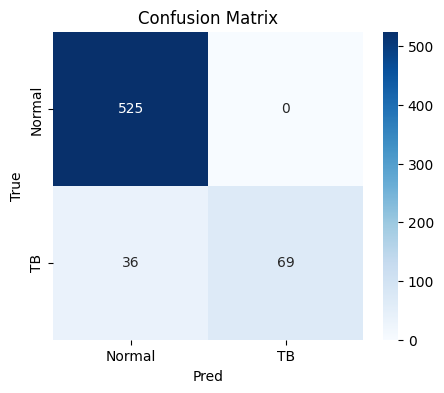

              precision    recall  f1-score   support

      Normal       0.94      1.00      0.97       525
Tuberculosis       1.00      0.66      0.79       105

    accuracy                           0.94       630
   macro avg       0.97      0.83      0.88       630
weighted avg       0.95      0.94      0.94       630



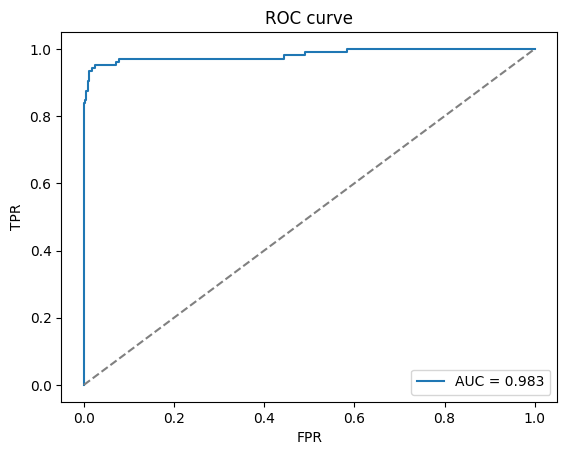

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# test
test_loss, test_acc, test_auc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Test AUC: {test_auc:.4f}")

# prédictions
y_true, y_probs = [], []
for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    y_probs.extend(model.predict(x_batch).ravel())

y_true = np.array(y_true)
y_probs = np.array(y_probs)
y_pred = (y_probs >= 0.5).astype(int)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","TB"], yticklabels=["Normal","TB"])
plt.xlabel("Pred")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# classification report
print(classification_report(y_true, y_pred, target_names=["Normal","Tuberculosis"]))

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve")
plt.legend()
plt.show()
